# Part 2 - FD-Schemes for European call

In [452]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

In [313]:
def solve_FTCS_scheme(K, T, r, sigma, X_min, X_max, T_steps = 1000, X_steps = 1000, sparse_matrices = True):
    tau_min = 0
    tau_max = T

    dX = (X_max - X_min) / (X_steps - 1)
    dtau = (tau_max - tau_min) / (T_steps - 1)

    o = (r - sigma**2 / 2) * dtau / 4 / dX
    p = 1/4 * sigma**2 * dtau / dX**2
    q = r * dtau / 2

    # Initialize the grid
    u = np.zeros((T_steps, X_steps))

    a_lower = np.repeat(2*(p - o), X_steps - 1)
    a_diagonal = np.repeat(1 - 4*p - 2*q, X_steps)
    a_upper = np.repeat(2*(p - o), X_steps - 1)

    A = np.diag(a_diagonal) + np.diag(a_upper, k=1) + np.diag(a_lower, k=-1)

    if sparse_matrices:
        A = sp.sparse.csc_matrix(A)

    # Initial vector
    u[0] = [max(0, np.exp(X_min + i*dX) - K) for i in range(X_steps)]

    for n in range(1, T_steps):
        tau = tau_min + n * dtau
        
        k = np.zeros(X_steps)
        k[-1] = 2 * (p - o) * (np.exp(X_max) - K * np.exp(r * tau))

        u[n] = A @ u[n-1] + k 

    return u


In [315]:
def solve_CN_scheme(K, T, r, sigma, X_min, X_max, T_steps = 1000, X_steps = 1000, sparse_matrices = True):
    tau_min = 0
    tau_max = T

    dX = (X_max - X_min) / (X_steps - 1)
    dtau = (tau_max - tau_min) / (T_steps - 1)

    o = (r - sigma**2 / 2) * dtau / 4 / dX
    p = 1/4 * sigma**2 * dtau / dX**2
    q = r * dtau / 2

    # Initialize the grid
    u = np.zeros((T_steps, X_steps))

    a_lower = np.repeat(-o + p, X_steps - 1)
    a_diagonal = np.repeat(1 - 2*p - q, X_steps)
    a_upper = np.repeat(o + p, X_steps - 1)

    A = np.diag(a_diagonal) + np.diag(a_upper, k=1) + np.diag(a_lower, k=-1)

    b_lower = np.repeat(o - p, X_steps - 1)
    b_diagonal = np.repeat(1 + 2*p + q, X_steps)
    b_upper = np.repeat(- o - p, X_steps - 1)

    B = np.diag(b_diagonal) + np.diag(b_upper, k=1) + np.diag(b_lower, k=-1)

    if sparse_matrices:
        A = sp.sparse.csc_matrix(A)
        B = sp.sparse.csc_matrix(B)

    # Initial vector
    u[0] = [max(0, np.exp(X_min + i*dX) - K) for i in range(X_steps)]

    for n in range(1, T_steps):
        tau = tau_min + n * dtau
        
        kA = np.zeros(X_steps)
        kA[-1] = (o + p) * (np.exp(X_max) - K * np.exp(r * tau))

        kB = np.zeros(X_steps)
        kB[-1] = (- o - p) * (np.exp(X_max) - K * np.exp(r * tau))

        if sparse_matrices:
            u[n] = sp.sparse.linalg.spsolve(B, A.dot(u[n-1]) + kA - kB)
        else:
            u[n] = np.linalg.solve(B, A.dot(u[n-1]) + kA - kB)

    return u

In [417]:
def interpolate_results(result_array, X_values, S):
    """
    Interpolates the result array to find the value of the option at a given S
    result_array and X_values should have the same shape
    """
    # print(f"X_values: {X_values}")
    # print(f"Results: {np.round(result_array, 1)}")
    # print(f"S: {S}, K: {K}")

    # Find the closest, lower X value
    X_values = np.array(X_values)
    sought_X = np.log(S)
    X_index = np.searchsorted(X_values, sought_X, side="right") - 1

    X_closest = X_values[X_index]

    # If the value is exactly at a grid point, return the value
    if X_closest == sought_X:
        return result_array[X_index]

    # Otherwise, interpolate
    X_diff = X_values[X_index + 1] - X_values[X_index]
    X_weight = (sought_X - X_values[X_index]) / X_diff

    return result_array[X_index] + X_weight * (result_array[X_index + 1] - result_array[X_index])

Time taken: 0.00201416015625
At S0 = 100, option price is 10.637892392225524
At S0 = 110, option price is 16.579807330578504
At S0 = 120, option price is 23.676568731222808


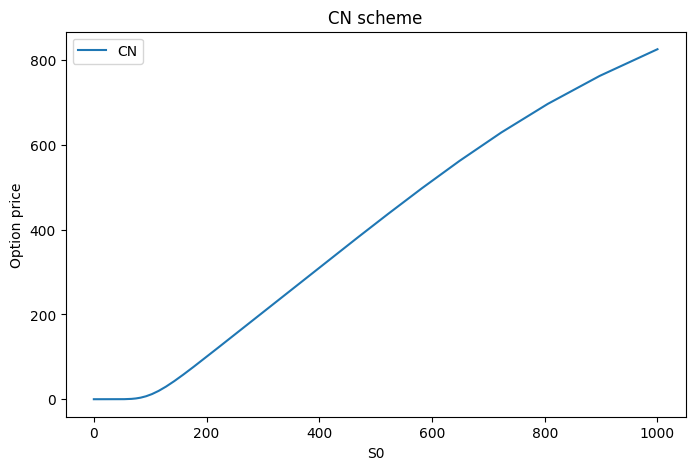

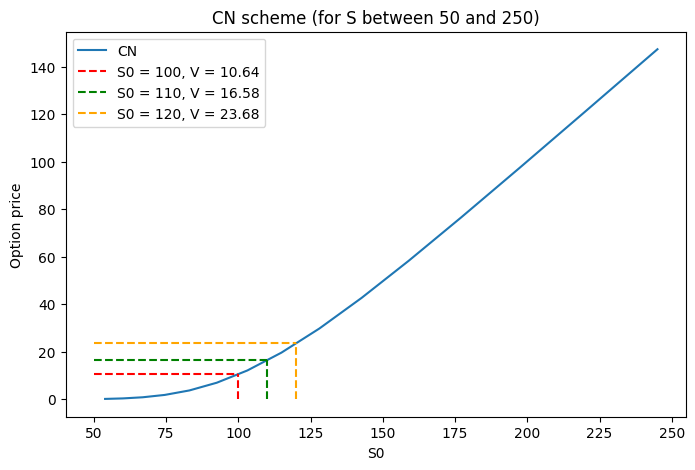

In [423]:
K = 110
T = 1
r = 0.04
sigma = 0.3
S_min = 1e-4
S_max = 1000
X_min = np.log(S_min)
X_max = np.log(S_max)
T_steps = 100
X_steps = 150

start = time.time()
result = solve_FTCS_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
print(f"Time taken: {time.time() - start}")

dX = (X_max - X_min) / (X_steps - 1)
X_values = [X_min + i*dX for i in range(X_steps)]

S0_results = []
for S0 in [100, 110, 120]:
    S0_result = interpolate_results(result[-1], X_values, S0)
    S0_results.append(S0_result)
    print(f"At S0 = {S0}, option price is {S0_result}")

# Last column is the option price at t = 0, for different S, so we can plot it
dX = (X_max - X_min) / (X_steps - 1)
S_values = [np.exp(X_min + i*dX) for i in range(X_steps)]

plt.figure(figsize=(8, 5))
plt.plot(S_values, result[-1], label='CN')
plt.legend()
plt.title(f'CN scheme')
plt.xlabel('S0')
plt.ylabel('Option price')
plt.show()


# Only print results for s between [1, 200]
print_range = [50, 250]
print_results = zip(S_values, result[-1])
print_results = filter(lambda x: x[0] > print_range[0] and x[0] < print_range[1], print_results)
print_results = np.array(list(print_results)).T
plt.figure(figsize=(8, 5))
plt.plot(print_results[0], print_results[1], label='CN')

colours = ['red', 'green', 'orange']
for i, S0 in enumerate([100, 110, 120]):
    plt.plot([S0, S0], [0, S0_results[i]], color=colours[i], linestyle='--')
    plt.plot([print_range[0], S0], [S0_results[i], S0_results[i]], color=colours[i], linestyle='--', label=f'S0 = {S0}, V = {S0_results[i]:.2f}')

plt.legend()
plt.title(f'CN scheme (for S between {print_range[0]} and {print_range[1]})')
plt.xlabel('S0')
plt.ylabel('Option price')
plt.show()

Time taken: 0.4100613594055176
At S0 = 100, option price is 9.625726740186428
At S0 = 110, option price is 15.12618953205178
At S0 = 120, option price is 21.78774442699019


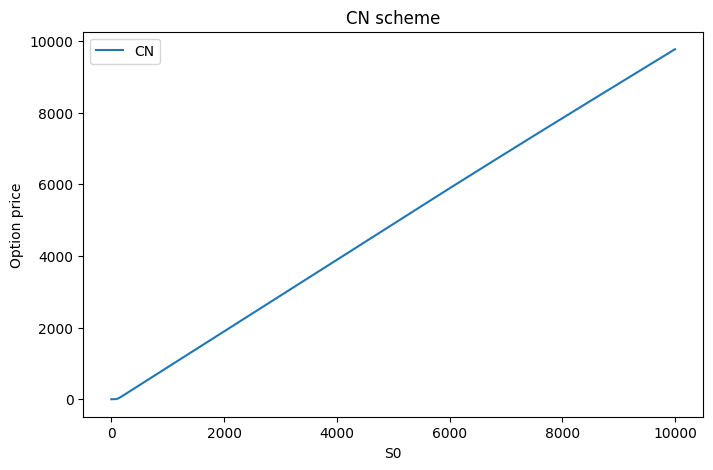

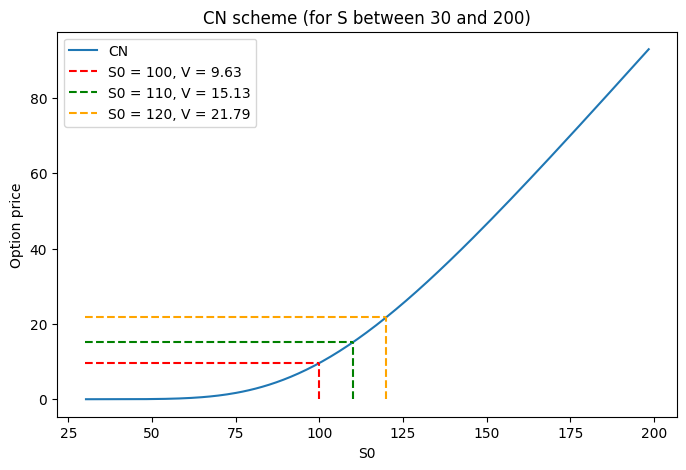

In [424]:
K = 110
T = 1
r = 0.04
sigma = 0.3
S_min = 1e-4
S_max = 1e4
X_min = np.log(S_min)
X_max = np.log(S_max)
T_steps = 1000
X_steps = 1500

start = time.time()
result = solve_CN_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
print(f"Time taken: {time.time() - start}")

dX = (X_max - X_min) / (X_steps - 1)
X_values = [X_min + i*dX for i in range(X_steps)]
S0_results = []
for S0 in [100, 110, 120]:
    S0_result = interpolate_results(result[-1], X_values, S0)
    S0_results.append(S0_result)
    print(f"At S0 = {S0}, option price is {S0_result}")

# Last column is the option price at t = 0, for different S, so we can plot it
dX = (X_max - X_min) / (X_steps - 1)
S_values = [np.exp(X_min + i*dX) for i in range(X_steps)]

plt.figure(figsize=(8, 5))
plt.plot(S_values, result[-1], label='CN')
plt.legend()
plt.title(f'CN scheme')
plt.xlabel('S0')
plt.ylabel('Option price')
plt.show()


# Only print results for s between [50, 150]
print_range = [30, 200]
print_results = zip(S_values, result[-1])
print_results = filter(lambda x: x[0] > print_range[0] and x[0] < print_range[1], print_results)
print_results = np.array(list(print_results)).T
plt.figure(figsize=(8, 5))
plt.plot(print_results[0], print_results[1], label='CN')

colours = ['red', 'green', 'orange']
for i, S0 in enumerate([100, 110, 120]):
    plt.plot([S0, S0], [0, S0_results[i]], color=colours[i], linestyle='--')
    plt.plot([print_range[0], S0], [S0_results[i], S0_results[i]], color=colours[i], linestyle='--', label=f'S0 = {S0}, V = {S0_results[i]:.2f}')

plt.legend()
plt.title(f'CN scheme (for S between {print_range[0]} and {print_range[1]})')
plt.xlabel('S0')
plt.ylabel('Option price')
plt.show()

## Option price with $S_0 = 110$ for varying grid size (both $X$ and $t$)

[54, 59, 65, 71, 79, 86, 95, 104, 115, 126, 138, 152, 167, 184, 202, 222, 244, 268, 294, 323, 355, 390, 429, 471, 517, 568, 625, 686, 754, 828, 910, 1000]


X_steps: 100%|██████████| 32/32 [00:01<00:00, 16.84it/s] 


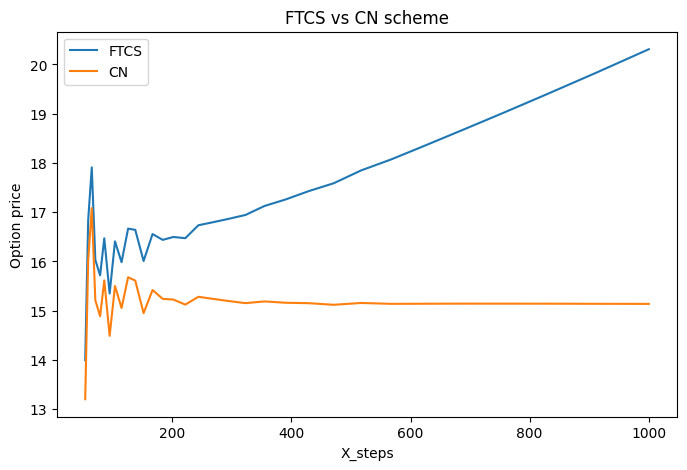

In [446]:
K = 110
T = 1
r = 0.04
sigma = 0.3
S_min = 1e-4
S_max = 1e4
X_min = np.log(S_min)
X_max = np.log(S_max)
S0 = 110

num_steps_values = [x for x in np.logspace(1,3,num=50,dtype='int') if x > 50]
print(num_steps_values)

FTCS_prices = []
CN_prices = []

for num_steps in tqdm(num_steps_values, desc='X_steps'):
    X_steps = num_steps
    T_steps = num_steps
    dX = (X_max - X_min) / (X_steps - 1)
    X_values = [X_min + i*dX for i in range(X_steps)]

    result = solve_FTCS_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
    FTCS_prices.append(interpolate_results(result[-1], X_values, S0))

    start = time.time()
    result = solve_CN_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
    CN_prices.append(interpolate_results(result[-1], X_values, S0))

plt.figure(figsize=(8, 5))
plt.plot(num_steps_values, FTCS_prices, label='FTCS')
plt.plot(num_steps_values, CN_prices, label='CN')
plt.legend()
plt.title(f'FTCS vs CN scheme')
plt.xlabel('X_steps')
plt.ylabel('Option price')
plt.show()

## Varying T_steps with X_steps = 400

Varying T_steps: 100%|██████████| 32/32 [00:01<00:00, 21.69it/s]


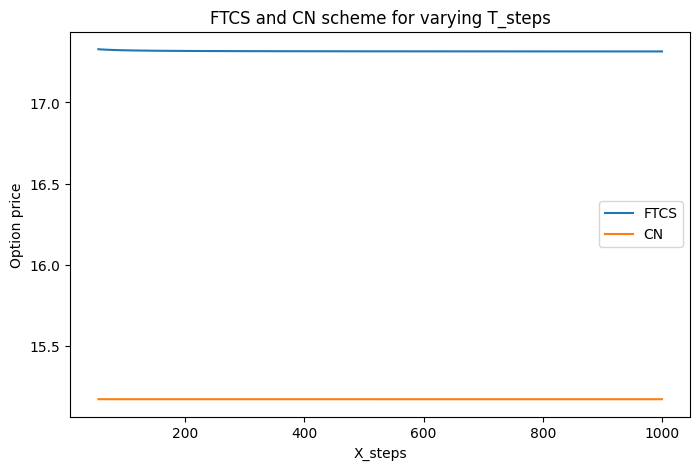

In [449]:
K = 110
T = 1
r = 0.04
sigma = 0.3
S_min = 1e-4
S_max = 1e4
X_min = np.log(S_min)
X_max = np.log(S_max)
S0 = 110
X_steps = 400

T_step_values = [x for x in np.logspace(1,3,num=50,dtype='int') if x > 50]

FTCS_prices = []
CN_prices = []

for T_steps in tqdm(T_step_values, desc='Varying T_steps'):
    dX = (X_max - X_min) / (X_steps - 1)
    X_values = [X_min + i*dX for i in range(X_steps)]

    result = solve_FTCS_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
    FTCS_prices.append(interpolate_results(result[-1], X_values, S0))

    start = time.time()
    result = solve_CN_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
    CN_prices.append(interpolate_results(result[-1], X_values, S0))

plt.figure(figsize=(8, 5))
plt.plot(T_step_values, FTCS_prices, label='FTCS')
plt.plot(T_step_values, CN_prices, label='CN')
plt.legend()
plt.title(f'FTCS and CN scheme for varying T_steps')
plt.xlabel('X_steps')
plt.ylabel('Option price')
plt.show()

## Varying X_steps with T_steps = 400

Varying X_steps: 100%|██████████| 32/32 [00:01<00:00, 19.26it/s]


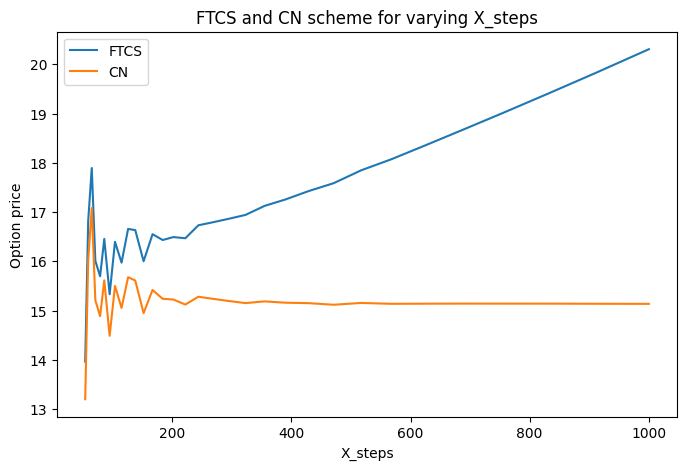

In [450]:
K = 110
T = 1
r = 0.04
sigma = 0.3
S_min = 1e-4
S_max = 1e4
X_min = np.log(S_min)
X_max = np.log(S_max)
S0 = 110
T_steps = 400

X_step_values = [x for x in np.logspace(1,3,num=50,dtype='int') if x > 50]

FTCS_prices = []
CN_prices = []

for X_steps in tqdm(X_step_values, desc='Varying X_steps'):
    dX = (X_max - X_min) / (X_steps - 1)
    X_values = [X_min + i*dX for i in range(X_steps)]

    result = solve_FTCS_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
    FTCS_prices.append(interpolate_results(result[-1], X_values, S0))

    start = time.time()
    result = solve_CN_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
    CN_prices.append(interpolate_results(result[-1], X_values, S0))

plt.figure(figsize=(8, 5))
plt.plot(X_step_values, FTCS_prices, label='FTCS')
plt.plot(X_step_values, CN_prices, label='CN')
plt.legend()
plt.title(f'FTCS and CN scheme for varying X_steps')
plt.xlabel('X_steps')
plt.ylabel('Option price')
plt.show()

In [453]:
def BS_valuation(S, T, r, K, sigma):
    # Black-Scholes formula for European option prices
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)



Varying X_steps: 100%|██████████| 32/32 [00:01<00:00, 19.94it/s]


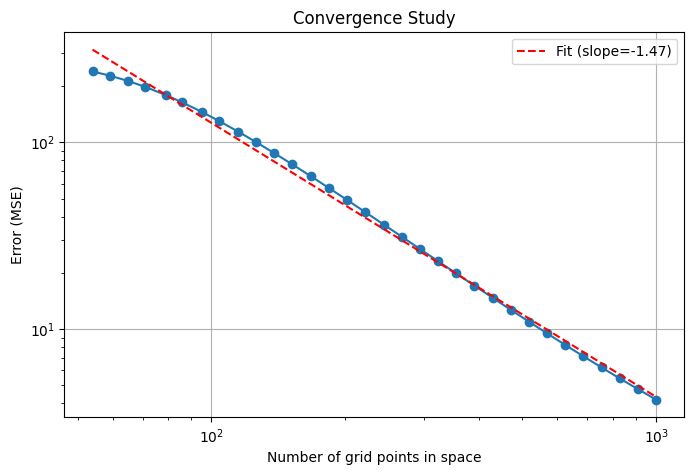

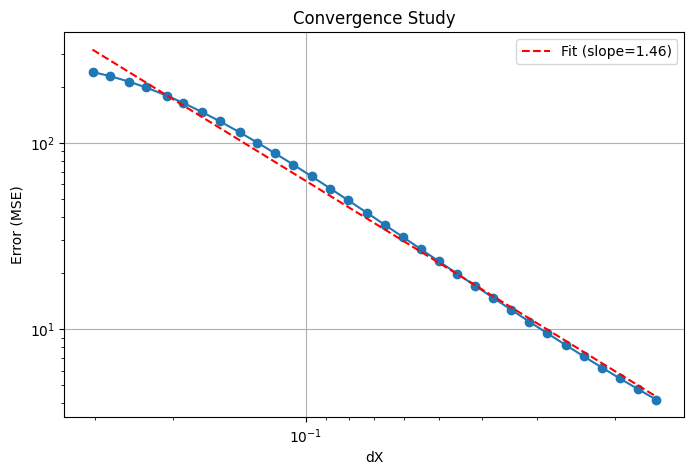

In [469]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
K = 110
T = 1
r = 0.04
sigma = 0.3
S_min = 1e-4
S_max = 1000
X_min = np.log(S_min)
X_max = np.log(S_max)
T_steps = 100
X_steps_values = [x for x in np.logspace(1,3,num=50,dtype='int') if x > 50]

# Initialize arrays to store errors
dX_values = []
errors = []

# Solve the scheme for each grid size
for X_steps in tqdm(X_steps_values, desc='Varying X_steps'):
    result = solve_CN_scheme(K, T, r, sigma, X_min, X_max, T_steps, X_steps)
    
    dX = (X_max - X_min) / (X_steps - 1)
    dX_values.append(dX)
    X_values = [X_min + i*dX for i in range(X_steps)]
    # Compute the exact solution or use a reference solution if available
    exact_solutions = [BS_valuation(np.exp(x), T, r, K, sigma) for x in X_values]
    
    # Compute Mean Squared Error (MSE)
    error = np.mean(np.power(result[-1] - exact_solutions, 2))
    errors.append(error)

# Plot errors versus grid size in log-log scale
plt.figure(figsize=(8, 5))
plt.loglog(X_steps_values, errors, marker='o', linestyle='-')

# Fit a line to the later half of the data
coeffs = np.polyfit(np.log(X_steps_values), np.log(errors), 1)
plt.loglog(X_steps_values, np.exp(coeffs[1]) * X_steps_values**coeffs[0], linestyle='--', color='red', label=f'Fit (slope={coeffs[0]:.2f})')


plt.xlabel('Number of grid points in space')
plt.ylabel('Error (MSE)')
plt.title('Convergence Study')
plt.grid(True)
plt.legend()
plt.show()

# Plot errors versus grid size in log-log scale
plt.figure(figsize=(8, 5))
plt.loglog(dX_values, errors, marker='o', linestyle='-')

# Fit a line to the later half of the data
coeffs = np.polyfit(np.log(dX_values), np.log(errors), 1)
plt.loglog(dX_values, np.exp(coeffs[1]) * dX_values**coeffs[0], linestyle='--', color='red', label=f'Fit (slope={coeffs[0]:.2f})')

# Reverse the x-axis
plt.gca().invert_xaxis()
plt.xlabel('dX')
plt.ylabel('Error (MSE)')
plt.title('Convergence Study')
plt.grid(True)
plt.legend()
plt.show()


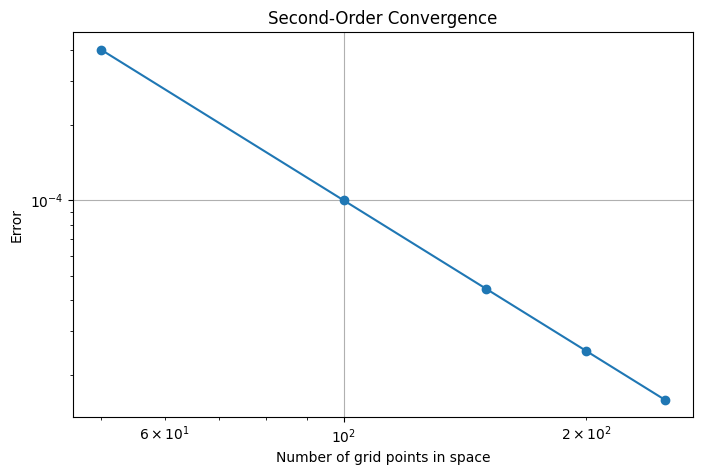

In [470]:
# Generate synthetic data for second-order convergence
grid_sizes = np.array([50, 100, 150, 200, 250])
errors = 1 / grid_sizes**2  # Quadratic decrease in errors

# Plot log-log plot to show second-order convergence
plt.figure(figsize=(8, 5))
plt.loglog(grid_sizes, errors, marker='o', linestyle='-')
plt.xlabel('Number of grid points in space')
plt.ylabel('Error')
plt.title('Second-Order Convergence')
plt.grid(True)
plt.show()